# Simulación de situación base y de posibles soluciones

In [ ]:
import json
import pandas as pd
import random
import heapq
from collections import deque, defaultdict
from datetime import datetime
import uuid
from pathlib import Path

class Node:
    def __init__(self, name, mu, servers):
        self.name = name
        self.mu = mu # tasa de servicio de cada servidor
        self.servers = servers # número de servidores
        self.busy = 0 # servidores ocupados
        self.queue = deque() # cola de clientes (client_id, tiempo_de_llegada_a_cola)
        # estadísticas
        self.area_q = 0.0 # integral de longitud de cola
        self.area_busy = 0.0 # integral de servidores ocupados
        self.num_served = 0 # número de clientes servidos

class Event:
    def __init__(self, time, kind, node_name, client_id, external=False):
        self.time = time # instante del evento
        self.kind = kind # 'arrival' o 'departure'
        self.node_name = node_name # nodo donde ocurre
        self.client_id = client_id # identificador del cliente
        self.external = external # si es llegada externa
    def __lt__(self, other):
        return self.time < other.time

## Función para simular situación base (antes de propuestas de soluciones a problemas)

En un hospital se ha organizado un proceso de atención a pacientes que transitan por diversas etapas. Al llegar al hospital, los pacientes ingresan a una de dos salas de registro, donde esperan su turno para procesar su admisión. Una vez completado el registro, los pacientes pasan a las salas de examinación; cada sala de registro deriva a su correspondiente sala de examinación. En estas salas se evalúa el estado de cada paciente para determinar los siguientes pasos en el proceso de atención médica.

Luego, los pacientes se dirigen a la sala de consulta asociada a la sala de examinación de la que proviene. La consulta incluye también el suministro de medicamentos e indicaciones necesarias para el alta médica. Una vez finalizada la consulta, el paciente finalizó su proceso en el hospital.

Los administradores del hospital buscan principalmente reducir los tiempos de espera de los pacientes.

**Información extra**

Aunque los pacientes llegan de forma aleatoria al hospital, la cantidad de pacientes que llega por hora a cada sala de registro se ha mantenido estable en dos cantidades respectivas de pacientes por hora fija. Esta cantidad puede saberse ya que el hospital registra la fecha y hora en la que cada paciente llega al hospital a esperar su turno para empezar su registro, y también almacena cuándo sale y entra de cada sala; de esta forma también puede saberse cuántos pacientes por hora entran y salen de cada etapa:

1. Sala de registro 1: Llegan 4 pacientes por hora y puede llevar a cabo el registro de 8 pacientes cada hora, en promedio. Cuenta con una sola persona atendiendo.
2. Sala de registro 2: Llegan 3 pacientes por hora y puede registrar 10 pacientes cada hora, en promedio. Cuenta con una sola persona atendiendo.
3. Sala de examinación 1: Los enfermeros pueden atender 6 pacientes cada hora, en promedio. Cuenta con un solo enfermero.
4. Sala de examinación 2: Pueden atender 6 pacientes cada hora, en promedio. Cuenta con un solo enfermero.
5. Sala de consulta 1: Los médicos pueden atender 2.5 pacientes cada hora, en promedio. Cuenta con dos médicos.
6. Sala de consulta 2: Pueden atender 3 pacientes cada hora, en promedio. Cuenta también con dos médicos.

Los administradores del hospital han determinado que cada sala de consulta debe mantenerse ocupada durante menos del 70% del tiempo para evitar que los médicos lleguen a un punto de fatiga excesiva.

In [ ]:
def simulate_base(T: float, lambda1: float, lambda2: float, nodes: dict[str, Node]
        ) -> dict[str, dict[str, float]]:
    """
    Simulación base (original) de la situación planteada inicialmente.
    
    Args:
        T: Tiempo de simulación (horas).
        lambda1: Tasa de llegada externa a 'reg1' (pacientes/hora).
        lambda2: Tasa de llegada externa a 'reg2' (pacientes/hora).
        nodes: Diccionario <nombre, Node>
    
    Returns:
        metrics: Diccionario <nombre_nodo, dict<nombre_metrica, float>>
            Explicación de las métricas:
            - Wq: Tiempo promedio en cola (horas).
            - W: Tiempo promedio en el sistema (horas).
            - Lq: Longitud promedio de la cola (número de clientes en cola).
            - L: Longitud promedio del sistema (número de clientes en el sistema).
            - rho: Proporción de tiempo ocupado por los servidores.
            - throughput: Rendimiento (número de clientes atendidos por hora).
    """
    future_events = []
    current_time = 0.0
    client_id = 0
    waits = defaultdict(list)

    # Se utiliza un heap para manejar la lista de eventos futuros:
    # "Heaps are binary trees for which every parent node has a value less than
    # or equal to any of its children. We refer to this condition as the heap 
    # invariant" (recuperado de: https://docs.python.org/3/library/heapq.html).
    # De esta forma, los eventos están ordenados de menor a mayor tiempo
    # (instante en que ocurren, almacenado en event.time).
    # El evento con menor tiempo es el primero en salir usando el método
    # heappop (que elimina y retorna el primer elemento de la lista).

    # Primeras llegadas externas a reg1 y reg2
    heapq.heappush(
        future_events, 
        Event(current_time+random.expovariate(lambda1), 'arrival', 'reg1', client_id, True),
    )
    client_id += 1

    heapq.heappush(
        future_events,
        Event(current_time+random.expovariate(lambda2), 'arrival', 'reg2', client_id, True),
    )
    client_id += 1

    while future_events:
        event: Event = heapq.heappop(future_events)

        if event.time > T:
            # si el evento es posterior al tiempo máximo de simulación, se
            # termina la simulación
            break

        # avanzar reloj de la simulación
        time_passed_since_last_event = event.time - current_time
        current_time = event.time

        # actualizar áreas (se usan para calcular las métricas de desempeño
        # de forma exacta para la simulación)
        for nd in nodes.values():
            # Qué representa el area_q:
            # area_q = integral de la longitud de la cola

            # Al dividir por T, se obtiene la longitud promedio de la cola (Lq)

            nd.area_q += len(nd.queue) * time_passed_since_last_event
            
            # Qué representa el area_busy:
            # area_busy = integral de cantidad de servidores ocupados

            # Al dividir por T (area_busy / T), se obtiene la cantidad promedio
            # de servidores ocupados, que es igual a la cantidad promedio de 
            # clientes siendo atendidos (L - Lq), pues cada servidor ocupado
            # atiende un cliente

            # Al dividir por T y por el número de servidores (area_busy / T / s),
            # se obtiene la proporción de tiempo ocupado por los servidores (rho),
            # pues la cantidad promedio de servidores ocupados es igual a la
            # cantidad promedio de clientes siendo atendidos (L - Lq) y se
            # calcula:
            # L = Lq + lambda/mu (fórmula del libro Hillier Lieberman)
            # area_busy / T = L - Lq = (Lq + lambda/mu) - Lq = lambda/mu
            # rho = lambda/(s * mu) (fórmula del libro Hillier Lieberman)
            # rho = (lambda / mu) * (1 / s)
            # lambda / mu = area_busy / T
            # rho = (area_busy / T) * (1 / s) = (area_busy / T) / s

            nd.area_busy += nd.busy * time_passed_since_last_event

        node = nodes[event.node_name]
        if event.kind == 'arrival':
            # reprogramar siguiente llegada externa
            if event.external:
                lam = lambda1 if event.node_name=='reg1' else lambda2
                heapq.heappush(future_events, Event(current_time+random.expovariate(lam),
                                             'arrival', event.node_name, client_id, True))
                client_id += 1
            # si hay servidor libre
            if node.busy < node.servers:
                node.busy += 1
                waits[node.name].append(0.0)
                dt = random.expovariate(node.mu)
                heapq.heappush(future_events, Event(current_time+dt, 'departure', node.name, event.client_id))
            else:
                node.queue.append((event.client_id, current_time))

        else:  # departure
            node.num_served += 1
            node.busy -= 1
            # si hay cola, atiende siguiente
            if node.queue:
                pid_q, t_arr = node.queue.popleft()
                waits[node.name].append(current_time - t_arr)
                node.busy += 1
                dt = random.expovariate(node.mu)
                heapq.heappush(future_events, Event(current_time+dt, 'departure', node.name, pid_q))
            # ruta al siguiente nodo
            if event.node_name == 'reg1':
                nxt = 'exam1'
            elif event.node_name == 'reg2':
                nxt = 'exam2'
            elif event.node_name == 'exam1':
                nxt = 'consult1'
            elif event.node_name == 'exam2':
                nxt = 'consult2'
            elif event.node_name.startswith('consult'):
                continue # en consulta sale del sistema
            else:
                raise ValueError(f"Evento de salida inesperado: {event.node_name}")
            # llegada inmediata
            heapq.heappush(future_events, Event(current_time, 'arrival', nxt, event.client_id, False))

    # calcular métricas
    metrics = {}
    for name, nd in nodes.items():
        Lq = nd.area_q / T
        L = nd.area_q / T + nd.area_busy / T
        rho = nd.area_busy / T / nd.servers
        Wq = sum(waits[name]) / len(waits[name]) if waits[name] else 0.0
        W = L / (nd.num_served / T) if nd.num_served > 0 else 0.0
        X   = nd.num_served / T
        metrics[name] = {
            'Wq': Wq,
            'W': W,
            'Lq': Lq,
            'L': L,
            'rho': rho,
            'throughput': X
        }
    return metrics

## (Habían más diseños del problema que después se eliminaron porque no se centraban en las instrucciones de la profesora)

## Simular situación de la solución 3

En la situación base, la sala de examinación 1 siempre dirige a la sala de consulta 1 y la sala de examinación 2 siempre dirige a la sala de consulta 2. 

En lugar de hacer estas direcciones, se utiliza un enfoque parecido al JSQ (join the shortest queue), pero para simplificar el modelo no se utiliza el JSQ como tal (que implica dirigir dinámicamente la salida a la estación de servicio con cola más corta en el momento), sino sólo su principio de enviar mayor proporción de las salidas de las salas de consulta a la sala de consulta con media de clientes en cola menor ($L_q$).

Para esto, se crea una nueva simulación con los siguientes pasos:


1. Correr la simulación base y extraer $L_{q_{c1}}$ (consulta 1) y $L_{q_{c2}}$ (consulta 2).
2. Definir probabilidades de enrutamiento fijas $p_{c1}$ = $\frac{L_{q_{c2}}}{L_{q_{c1}}+L_{q_{c2}}}, p_{c2}$ = $\frac{L_{q_{c1}}}{L_{q_{c1}}+L_{q_{c2}}}$ (envías más flujo al nodo que tenía menor cola promedio en la simulación base; hay una probabilidad de $p_{c1}$ de enviar el paciente de la sala de examinación—tanto para la sala 1 como para la sala 2—a la sala de consulta 1).
3. Simular de nuevo con esas probabilidades estáticas ya asignadas.
4. Comparar métricas de desempeño $W$, $L$, $W_q$, $L_q$ y $\rho$ (rho) antes y después.

$p_{c1}$ termina dando 0.1, lo que da un 90% de flujo hacia el consultorio 2. Esto desborda la cantidad de clientes que entran a la estación de servicio comparado con la cantidad que puede atender por hora, por lo que nunca alcanza un estado estable. Por esto, **esta solución no es óptima pero se utiliza en la solución 4 el mismo proceso pero utilizando mu (tasa de servicio) para calcular la probabilidad de enrutamiento**. La solución 4 termina mejorando bastante los tiempos de espera en el consultorio 1 a cambio de un aumento muy pequeño en el consultorio 2.

In [ ]:
def simulate_solution3(T: float, lambda1: float, lambda2: float, nodes: dict[str, Node],
        p_to_consult1: float) -> dict[str, dict[str, float]]:
    """
    Simulación de la solución 3: Enviar mayor proporción de pacientes salientes
    de las salas de consultas a la sala de consulta con media de clientes en cola menor.
    
    Args:
        T: Tiempo de simulación (horas).
        lambda1: Tasa de llegada externa a 'reg1' (pacientes/hora).
        lambda2: Tasa de llegada externa a 'reg2' (pacientes/hora).
        nodes: Diccionario <nombre, Node>
        p_to_consult1: Probabilidad de un paciente de dirigirse a 'consult1'
            desde una sala de examinación.
    
    Returns:
        metrics: Diccionario <nombre_nodo, dict<nombre_metrica, float>>
            Explicación de las métricas:
            - Wq: Tiempo promedio en cola (horas).
            - W: Tiempo promedio en el sistema (horas).
            - Lq: Longitud promedio de la cola (número de clientes en cola).
            - L: Longitud promedio del sistema (número de clientes en el sistema).
            - rho: Proporción de tiempo ocupado por los servidores.
            - throughput: Rendimiento (número de clientes atendidos por hora).
    """
    future_events = []
    t = 0.0
    client_id = 0
    waits = defaultdict(list)

    # primeras llegadas externas a reg1 y reg2
    heapq.heappush(future_events, Event(random.expovariate(lambda1), 'arrival', 'reg1', client_id, True))
    client_id += 1
    heapq.heappush(future_events, Event(random.expovariate(lambda2), 'arrival', 'reg2', client_id, True))
    client_id += 1

    while future_events:
        ev = heapq.heappop(future_events)
        if ev.time > T:
            break
        # avanzar reloj y actualizar áreas
        dt_global = ev.time - t
        t = ev.time
        for nd in nodes.values():
            nd.area_q += len(nd.queue)*dt_global
            nd.area_busy += nd.busy*dt_global

        node = nodes[ev.node_name]
        if ev.kind == 'arrival':
            # reprogramar siguiente llegada externa
            if ev.external:
                lam = lambda1 if ev.node_name=='reg1' else lambda2
                heapq.heappush(future_events, Event(t+random.expovariate(lam),
                                             'arrival', ev.node_name, client_id, True))
                client_id += 1
            # si hay servidor libre
            if node.busy < node.servers:
                node.busy += 1
                waits[node.name].append(0.0)
                dt = random.expovariate(node.mu)
                heapq.heappush(future_events, Event(t+dt, 'departure', node.name, ev.client_id))
            else:
                node.queue.append((ev.client_id, t))

        else:  # departure
            node.num_served += 1
            node.busy -= 1
            # si hay cola, atiende siguiente
            if node.queue:
                pid_q, t_arr = node.queue.popleft()
                waits[node.name].append(t - t_arr)
                node.busy += 1
                dt = random.expovariate(node.mu)
                heapq.heappush(future_events, Event(t+dt, 'departure', node.name, pid_q))
            # ruta al siguiente nodo
            if ev.node_name == 'reg1':
                nxt = 'exam1'
            elif ev.node_name == 'reg2':
                nxt = 'exam2'
            elif ev.node_name.startswith('exam'):
                # (*Cambio de esta solución*)
                # Routing estático
                nxt = 'consult1' if random.random() < p_to_consult1 else 'consult2'
            elif ev.node_name.startswith('consult'):
                continue # en consulta sale del sistema
            else:
                raise ValueError(f"Evento de salida inesperado: {ev.node_name}")
            # llegada inmediata
            heapq.heappush(future_events, Event(t, 'arrival', nxt, ev.client_id, False))

    # calcular métricas
    metrics = {}
    for name, nd in nodes.items():
        Lq = nd.area_q / T
        L = nd.area_q / T + nd.area_busy / T
        rho = nd.area_busy / T / nd.servers
        Wq = sum(waits[name]) / len(waits[name]) if waits[name] else 0.0
        W = L / (nd.num_served / T) if nd.num_served > 0 else 0.0
        X   = nd.num_served / T
        metrics[name] = {
            'Wq': Wq,
            'W': W,
            'Lq': Lq,
            'L': L,
            'rho': rho,
            'throughput': X
        }
    return metrics

## Simular situación de la solución 4

Para solucionar el problema de $\lambda_{c1} > \mu_{c1}$ de la solución 3, se sigue el mismo proceso sólo que se cambia:

2. Definir probabilidades de enrutamiento fijas $p_{c1}$ = $\frac{\mu_{c1}}{\mu_{c1}+\mu_{c2}}, p_{c2}$ = $\frac{\mu_{c1}}{\mu_{c1}+\mu_{c2}}$ (envías más flujo al nodo que tenía mayor tasa de servicio en la simulación base—cabe recordar que las tasas de servicio son las mismas en la simulación base y en la simulación de la solución 3 y 4).

De esta forma, se calcula la probabilidad no en función de $L_{q}$, sino de la capacidad de servicio de cada consulta. De esta forma, ambas salas quedan equilibradas y estables, pues los $\rho$ terminan siendo iguales en ambas salas de consulta y menores a 1 (como se explica en `Interpretación de los resultados` al final).

Utiliza la misma función de simulación que la solución 3, pues sólo cambia el valor asignado al parámetro `p_to_consult1`.

## Simular situación de la solución 5

A la solución 4 se le añade otra mejora. **Se juntan las dos salas de examinación en una sola**, teniendo un solo nodo con dos servidores y cola compartida (generalmente dos instalaciones de servicio separadas que realizan la misma función con la misma tasa de servicio son menos eficientes que una sola instalación de servicio con dos servidores).

Utiliza la misma función de simulación que la solución 3, sólo cambia que la salidas de reg1 y reg2 se dirigen únicamente hacia exam, en lugar de exam1 y exam2.

In [ ]:
def simulate_solution5(T: float, lambda1: float, lambda2: float, nodes: dict[str, Node],
        p_to_consult1: float) -> dict[str, dict[str, float]]:
    """
    Simulación de la solución 5: Misma función de simulación que la solución 3,
    sólo cambia que la salidas de reg1 y reg2 se dirigen únicamente hacia exam,
    en lugar de exam1 y exam2.
    
    Args:
        T: Tiempo de simulación (horas).
        lambda1: Tasa de llegada externa a 'reg1' (pacientes/hora).
        lambda2: Tasa de llegada externa a 'reg2' (pacientes/hora).
        nodes: Diccionario <nombre, Node>
        p_to_consult1: Probabilidad de un paciente de dirigirse a 'consult1'
            desde una sala de examinación.
    
    Returns:
        metrics: Diccionario <nombre_nodo, dict<nombre_metrica, float>>
            Explicación de las métricas:
            - Wq: Tiempo promedio en cola (horas).
            - W: Tiempo promedio en el sistema (horas).
            - Lq: Longitud promedio de la cola (número de clientes en cola).
            - L: Longitud promedio del sistema (número de clientes en el sistema).
            - rho: Proporción de tiempo ocupado por los servidores.
            - throughput: Rendimiento (número de clientes atendidos por hora).
    """
    future_events = []
    t = 0.0
    client_id = 0
    waits = defaultdict(list)

    # primeras llegadas externas a reg1 y reg2
    heapq.heappush(future_events, Event(random.expovariate(lambda1), 'arrival', 'reg1', client_id, True))
    client_id += 1
    heapq.heappush(future_events, Event(random.expovariate(lambda2), 'arrival', 'reg2', client_id, True))
    client_id += 1

    while future_events:
        ev = heapq.heappop(future_events)
        if ev.time > T:
            break
        # avanzar reloj y actualizar áreas
        dt_global = ev.time - t
        t = ev.time
        for nd in nodes.values():
            nd.area_q += len(nd.queue)*dt_global
            nd.area_busy += nd.busy*dt_global

        node = nodes[ev.node_name]
        if ev.kind == 'arrival':
            # reprogramar siguiente llegada externa
            if ev.external:
                lam = lambda1 if ev.node_name=='reg1' else lambda2
                heapq.heappush(future_events, Event(t+random.expovariate(lam),
                                             'arrival', ev.node_name, client_id, True))
                client_id += 1
            # si hay servidor libre
            if node.busy < node.servers:
                node.busy += 1
                waits[node.name].append(0.0)
                dt = random.expovariate(node.mu)
                heapq.heappush(future_events, Event(t+dt, 'departure', node.name, ev.client_id))
            else:
                node.queue.append((ev.client_id, t))

        else:  # departure
            node.num_served += 1
            node.busy -= 1
            # si hay cola, atiende siguiente
            if node.queue:
                pid_q, t_arr = node.queue.popleft()
                waits[node.name].append(t - t_arr)
                node.busy += 1
                dt = random.expovariate(node.mu)
                heapq.heappush(future_events, Event(t+dt, 'departure', node.name, pid_q))
            # ruta al siguiente nodo
            if ev.node_name.startswith('reg'):
                # (*Cambio de esta solución*)
                # Todas las salas de registro se dirigen a la misma sala de 
                # examinación
                nxt = 'exam'
            elif ev.node_name.startswith('exam'):
                nxt = 'consult1' if random.random() < p_to_consult1 else 'consult2'
            elif ev.node_name.startswith('consult'):
                continue # en consulta sale del sistema
            else:
                raise ValueError(f"Evento de salida inesperado: {ev.node_name}")
            # llegada inmediata
            heapq.heappush(future_events, Event(t, 'arrival', nxt, ev.client_id, False))

    # calcular métricas
    metrics = {}
    for name, nd in nodes.items():
        Lq = nd.area_q / T
        L = nd.area_q / T + nd.area_busy / T
        rho = nd.area_busy / T / nd.servers
        Wq = sum(waits[name]) / len(waits[name]) if waits[name] else 0.0
        W = L / (nd.num_served / T) if nd.num_served > 0 else 0.0
        X   = nd.num_served / T
        metrics[name] = {
            'Wq': Wq,
            'W': W,
            'Lq': Lq,
            'L': L,
            'rho': rho,
            'throughput': X
        }
    
    return metrics

## Ejecutar simulaciones

In [801]:

def save_simulation(simulation_name: str, run_dir: Path, metrics: dict[str, dict[str, float]], nodes: dict[str, Node],
                    lambda1: float, lambda2: float, T: float, seed: int) -> None:
    # Guardar los resultados de la simulación en runs/{timestamp} {unique_id}/{simulation_name}
    path = run_dir / simulation_name
    path.mkdir(parents=True, exist_ok=True)

    metrics_df = pd.DataFrame(metrics).T
    metrics_df = metrics_df[['Wq', 'Lq', 'rho', 'throughput']].round(3)
    results_path = path / 'simulation_results.csv'
    metrics_df.to_csv(results_path)
    print(f"Resultados de la simulación {simulation_name} guardados en '{results_path}'.")

    params = {
        'seed': seed,
        'nodes': {name: {'mu': node.mu, 'servers': node.servers} for name, node in nodes.items()},
        'lambda1': lambda1,
        'lambda2': lambda2,
        'T': T,
    }
    params_path = path / 'simulation_params.json'
    with params_path.open('w') as f:
        json.dump(params, f, indent=4)
    print(f"Parámetros de la simulación {simulation_name} guardados en '{params_path}'.")

def display_simulation_metrics(simulation_name: str, metrics: dict[str, dict[str, float]]):
    # Convertir los resultados de la simulación en un DataFrame y mostrarlo como una tabla
    df = pd.DataFrame(metrics).T
    # show always 4 decimales even if it's 0.0000
    df = df.style.format(na_rep='0.0000')
    print("Resultados de la simulación:", simulation_name)
    display(df)

### Parámetros del modelo

In [802]:
import copy
# Para obtener exactamente los mismos resultados de una run en específico, 
# sólo usa la misma semilla, mismos parámetros y mismos nodos.

# Horas de simulación (entre mayor sea, más parecidos son los resultados
# a los calculados manualmente con fórmulas)
T = 100000.0*2
seed = random.randint(1, 100000) # semilla aleatoria
random.seed(seed)
print(f"Semilla aleatoria: {seed}")

# Parámetros de llegada externa (pacientes/hora)
lambda1 = 4.0 # a reg1
lambda2 = 3.0 # a reg2

# Modelo base
nodes_base = {
    'reg1':    Node('reg1',     mu=8.0,  servers=1),
    'reg2':    Node('reg2',     mu=10.0, servers=1),
    'exam1':   Node('exam1',    mu=6.0,  servers=1),
    'exam2':   Node('exam2',    mu=6.0,  servers=1),
    'consult1':Node('consult1', mu=2.5,  servers=2),
    'consult2':Node('consult2', mu=3.0,  servers=2),
}

# Modelo solución 3
nodes_solution3 = copy.deepcopy(nodes_base)

# Modelo solución 4
nodes_solution4 = copy.deepcopy(nodes_solution3)

# Modelo solución 5
nodes_solution5 = {
    'reg1':    Node('reg1',     mu=8.0,  servers=1),
    'reg2':    Node('reg2',     mu=10.0, servers=1),
    'exam':    Node('exam',     mu=6,    servers=2),
    'consult1':Node('consult1', mu=2.5,  servers=2),
    'consult2':Node('consult2', mu=3.0,  servers=2),
}

Semilla aleatoria: 1490


### Correr simulaciones

In [803]:
# Uncomment to generate a random seed each time this cell is run
seed = random.randint(1, 100000) # semilla aleatoria
random.seed(seed)
print(f"Semilla aleatoria: {seed}")

# Crear un directorio único dentro de "runs"
timestamp = datetime.now().strftime("%d-%m-%Y %H_%M_%S")
unique_id = uuid.uuid4().hex[:6] # ID único

# Crear la carpeta común usando timestamp y unique_id
run_dir = Path("runs") / f"{timestamp} {unique_id}"
run_dir.mkdir(parents=True, exist_ok=True)

print("------ Simulación base ------")
base_metrics = simulate_base(T, lambda1, lambda2, copy.deepcopy(nodes_base))
display_simulation_metrics("Base", base_metrics)
save_simulation("base", run_dir, base_metrics, nodes_base, lambda1, lambda2, T, seed)

print("------ Simulación de la solución 3 ------")
# Utilizar Lq de la simulación base para calcular la proporción de pacientes que van a consult1
L_q1 = base_metrics['consult1']['Lq']
L_q2 = base_metrics['consult2']['Lq']
p_to_consult1 = L_q2 / (L_q1 + L_q2)
print(f"Proporción de pacientes que van a consult1: {p_to_consult1:.4f}")
solution3_metrics = simulate_solution3(T, lambda1, lambda2, copy.deepcopy(nodes_solution3), p_to_consult1)
display_simulation_metrics("Solución 3", solution3_metrics)
save_simulation("solution3", run_dir, solution3_metrics, nodes_solution3, lambda1, lambda2, T, seed)

print("------ Simulación de la solución 4 ------")
# Utilizar mu de la simulación base para calcular la proporción de pacientes que van a consult1
mu1 = nodes_base['consult1'].mu
mu2 = nodes_base['consult2'].mu
p_to_consult1 = mu1 / (mu1 + mu2)
print(f"Proporción de pacientes que van a consult1: {p_to_consult1:.4f}")
solution4_metrics = simulate_solution3(T, lambda1, lambda2, copy.deepcopy(nodes_solution4), p_to_consult1)
display_simulation_metrics("Solución 4", solution4_metrics)
save_simulation("solution4", run_dir, solution4_metrics, nodes_solution4, lambda1, lambda2, T, seed)

print("------ Simulación de la solución 5 ------")
print(f"Proporción de pacientes que van a consult1: {p_to_consult1:.4f}")
solution5_metrics = simulate_solution5(T, lambda1, lambda2, copy.deepcopy(nodes_solution5), p_to_consult1)
display_simulation_metrics("Solución 5", solution5_metrics)
save_simulation("solution5", run_dir, solution5_metrics, nodes_solution5, lambda1, lambda2, T, seed)


Semilla aleatoria: 68388


------ Simulación base ------
Resultados de la simulación: Base


,Wq,W,Lq,L,rho,throughput
reg1,0.125582,0.250555,0.502681,1.002901,0.500220,4.002720
reg2,0.042686,0.142737,0.127973,0.427924,0.299951,2.997985
exam1,0.335230,0.501703,1.341830,2.008175,0.666345,4.002720
exam2,0.165894,0.332611,0.497347,0.997155,0.499808,2.997965
consult1,0.734512,1.135774,2.940047,4.546185,0.803069,4.002720
consult2,0.109117,0.442575,0.327128,1.326821,0.499846,2.997960


Resultados de la simulación base guardados en 'runs\11-05-2025 03_35_59 346c70\base\simulation_results.csv'.
Parámetros de la simulación base guardados en 'runs\11-05-2025 03_35_59 346c70\base\simulation_params.json'.
------ Simulación de la solución 3 ------
Proporción de pacientes que van a consult1: 0.1001
Resultados de la simulación: Solución 3


,Wq,W,Lq,L,rho,throughput
reg1,0.125351,0.250374,0.502050,1.002789,0.500738,4.005160
reg2,0.042847,0.142955,0.128599,0.429064,0.300465,3.001385
exam1,0.335063,0.501876,1.341981,2.010092,0.668111,4.005155
exam2,0.167459,0.333891,0.502609,1.002133,0.499524,3.001380
consult1,0.008510,0.409357,0.005954,0.286322,0.140184,0.699445
consult2,4673.051495,4915.802839,29511.226758,29513.226713,0.999977,6.003745


Resultados de la simulación solution3 guardados en 'runs\11-05-2025 03_35_59 346c70\solution3\simulation_results.csv'.
Parámetros de la simulación solution3 guardados en 'runs\11-05-2025 03_35_59 346c70\solution3\simulation_params.json'.
------ Simulación de la solución 4 ------
Proporción de pacientes que van a consult1: 0.4545
Resultados de la simulación: Solución 4


,Wq,W,Lq,L,rho,throughput
reg1,0.124835,0.249795,0.499991,1.000487,0.500495,4.005230
reg2,0.042913,0.142874,0.128728,0.428587,0.299860,2.999765
exam1,0.334520,0.501102,1.339830,2.007030,0.667199,4.005230
exam2,0.165337,0.331709,0.495973,0.995048,0.499075,2.999765
consult1,0.276398,0.676834,0.879643,2.154037,0.637197,3.182520
consult2,0.226448,0.559662,0.865590,2.139285,0.636847,3.822460


Resultados de la simulación solution4 guardados en 'runs\11-05-2025 03_35_59 346c70\solution4\simulation_results.csv'.
Parámetros de la simulación solution4 guardados en 'runs\11-05-2025 03_35_59 346c70\solution4\simulation_params.json'.
------ Simulación de la solución 5 ------
Proporción de pacientes que van a consult1: 0.4545
Resultados de la simulación: Solución 5


,Wq,W,Lq,L,rho,throughput
reg1,0.124316,0.249215,0.497090,0.996512,0.499422,3.998600
reg2,0.042727,0.142894,0.128115,0.428460,0.300345,2.998460
exam,0.085898,0.252441,0.601034,1.766338,0.582652,6.997040
consult1,0.270957,0.670718,0.860238,2.129402,0.634582,3.174810
consult2,0.226911,0.560379,0.867307,2.141897,0.637295,3.822230


Resultados de la simulación solution5 guardados en 'runs\11-05-2025 03_35_59 346c70\solution5\simulation_results.csv'.
Parámetros de la simulación solution5 guardados en 'runs\11-05-2025 03_35_59 346c70\solution5\simulation_params.json'.


## Calcular manualmente las medidas de desempeño (por medio de fórmulas)

In [804]:
import math

# Para sistemas M/M/1
def mm1_metrics(lmbda, mu):
    # Utilización
    rho = lmbda / mu
    # Tiempo promedio en cola: Wq = (ρ^2) / [λ(1-ρ)]
    Wq = (rho**2) / (lmbda * (1 - rho))
    # Tiempo promedio en el nodo: W = Wq + 1/μ
    W = Wq + 1/mu
    # Número promedio en cola: Lq = λ * Wq
    Lq = lmbda * Wq
    # Número promedio en el sistema: L = λ * W
    L = lmbda * W
    return {'Wq': Wq, 'W': W, 'Lq': Lq, 'L': L, 'rho': rho}

# Para sistemas M/M/s
def mmc_metrics(lmbda, mu, c):
    # Utilización (por servidor)
    rho = lmbda / (c * mu)
    # Calcular P0 (probabilidad de 0 clientes en el sistema)
    sum_terms = sum([(c * rho)**n / math.factorial(n) for n in range(c)])
    term = (c * rho)**c / (math.factorial(c) * (1 - rho))
    P0 = 1.0 / (sum_terms + term)
    
    # Promedio de clientes en cola (Lq)
    Lq = P0 * ((c * rho)**c) * rho / (math.factorial(c) * ((1 - rho)**2))
    # Tiempo promedio en cola
    Wq = Lq / lmbda
    # Tiempo promedio en el sistema
    W = Wq + 1/mu
    # Número promedio en el sistema
    L = lmbda * W
    return {'Wq': Wq, 'W': W, 'Lq': Lq, 'L': L, 'rho': rho}

def store_manual_metrics_to_dict(metrics_dict: dict[str, dict[str, float]], 
        node: Node, lambd: float) -> None:
    """
    Almacena las métricas calculadas manualmente en un diccionario.
    
    Args:
        metrics_dict: Diccionario donde se almacenarán las métricas.
        node: Nodo para el cual se calcularán las métricas.
        lambd: Tasa de llegada al nodo.
    """
    if node.servers == 1:
        metrics = mm1_metrics(lambd, node.mu)
    else:
        metrics = mmc_metrics(lambd, node.mu, node.servers)
    metrics_dict[node.name] = metrics

### Caso base

In [805]:
print("Medidas de desempeño (cálculo manual) para el caso base:")

base_metrics_manual = {}

store_manual_metrics_to_dict(base_metrics_manual, nodes_base['reg1'], lambda1)
store_manual_metrics_to_dict(base_metrics_manual, nodes_base['reg2'], lambda2)
store_manual_metrics_to_dict(base_metrics_manual, nodes_base['exam1'], lambda1)
store_manual_metrics_to_dict(base_metrics_manual, nodes_base['exam2'], lambda2)
store_manual_metrics_to_dict(base_metrics_manual, nodes_base['consult1'], lambda1)
store_manual_metrics_to_dict(base_metrics_manual, nodes_base['consult2'], lambda2)

df_base_manual = pd.DataFrame(base_metrics_manual).T

display(df_base_manual)

Medidas de desempeño (cálculo manual) para el caso base:


,Wq,W,Lq,L,rho
reg1,0.125000,0.250000,0.500000,1.000000,0.500000
reg2,0.042857,0.142857,0.128571,0.428571,0.300000
exam1,0.333333,0.500000,1.333333,2.000000,0.666667
exam2,0.166667,0.333333,0.500000,1.000000,0.500000
consult1,0.711111,1.111111,2.844444,4.444444,0.800000
consult2,0.111111,0.444444,0.333333,1.333333,0.500000


### Caso de la solución 4

In [806]:
print("Medidas de desempeño (cálculo manual) para la solución 4:")

solution4_metrics_manual = {}

store_manual_metrics_to_dict(solution4_metrics_manual, nodes_solution4['reg1'], lambda1)
store_manual_metrics_to_dict(solution4_metrics_manual, nodes_solution4['reg2'], lambda2)
store_manual_metrics_to_dict(solution4_metrics_manual, nodes_solution4['exam1'], lambda1)
store_manual_metrics_to_dict(solution4_metrics_manual, nodes_solution4['exam2'], lambda2)

# Calcular las probabilidades de enrutar a los consultorios usando las tasas de servicio
mu1 = nodes_solution4['consult1'].mu
mu2 = nodes_solution4['consult2'].mu
p_consult1 = mu1 / (mu1 + mu2)
p_consult2 = 1 - p_consult1

# Tasa de llegada total a los consultorios: suma de los flujos de exam1 y exam2 (4 + 3)
lambda_total = lambda1 + lambda2
lambda_consult1 = lambda_total * p_consult1
lambda_consult2 = lambda_total * p_consult2

store_manual_metrics_to_dict(solution4_metrics_manual, nodes_solution4['consult1'], lambda_consult1)
store_manual_metrics_to_dict(solution4_metrics_manual, nodes_solution4['consult2'], lambda_consult2)

df_solution4_manual = pd.DataFrame(solution4_metrics_manual).T

display(df_solution4_manual)

Medidas de desempeño (cálculo manual) para la solución 4:


,Wq,W,Lq,L,rho
reg1,0.125000,0.250000,0.500000,1.000000,0.500000
reg2,0.042857,0.142857,0.128571,0.428571,0.300000
exam1,0.333333,0.500000,1.333333,2.000000,0.666667
exam2,0.166667,0.333333,0.500000,1.000000,0.500000
consult1,0.272222,0.672222,0.866162,2.138889,0.636364
consult2,0.226852,0.560185,0.866162,2.138889,0.636364


### Caso de la solución 5

In [807]:
print("Medidas de desempeño (cálculo manual) para la solución 5:")

solution5_metrics_manual = {}

store_manual_metrics_to_dict(solution5_metrics_manual, nodes_solution5['reg1'], lambda1)
store_manual_metrics_to_dict(solution5_metrics_manual, nodes_solution5['reg2'], lambda2)
store_manual_metrics_to_dict(solution5_metrics_manual, nodes_solution5['exam'], lambda1+lambda2)

# Calcular las probabilidades de enrutar a los consultorios usando las tasas de servicio
mu1 = nodes_solution4['consult1'].mu
mu2 = nodes_solution4['consult2'].mu
p_consult1 = mu1 / (mu1 + mu2)
p_consult2 = 1 - p_consult1

# Tasa de llegada total a los consultorios: suma de los flujos de exam1 y exam2 (4 + 3)
lambda_total = lambda1 + lambda2
lambda_consult1 = lambda_total * p_consult1
lambda_consult2 = lambda_total * p_consult2

store_manual_metrics_to_dict(solution5_metrics_manual, nodes_solution5['consult1'], lambda_consult1)
store_manual_metrics_to_dict(solution5_metrics_manual, nodes_solution5['consult2'], lambda_consult2)

df_solution5_manual = pd.DataFrame(solution5_metrics_manual).T

display(df_solution5_manual)

Medidas de desempeño (cálculo manual) para la solución 5:


,Wq,W,Lq,L,rho
reg1,0.125000,0.250000,0.500000,1.000000,0.500000
reg2,0.042857,0.142857,0.128571,0.428571,0.300000
exam,0.085965,0.252632,0.601754,1.768421,0.583333
consult1,0.272222,0.672222,0.866162,2.138889,0.636364
consult2,0.226852,0.560185,0.866162,2.138889,0.636364


## Comparar medidas de desempeño obtenidas con simulaciones y obtenidas manualmente

In [808]:

import matplotlib.pyplot as plt

metric_names = ['Wq', 'W', 'Lq', 'L', 'rho']

def show_simulated_vs_manual_metrics_comparison_graphs(
        simulation_name:str, df_simulation: pd.DataFrame,
        df_manual: pd.DataFrame) -> None:
    """
    Muestra un gráfico de comparación entre las métricas simuladas y manuales.
    
    Args:
        simulation_name: Nombre de la simulación.
        df_simulation: DataFrame con las métricas simuladas.
        df_manual: DataFrame con las métricas manuales.
    """
    print(f"Comparación de métricas entre simulación y cálculo manual para {simulation_name}:")
    nodes = df_simulation.index.tolist()

    df_simulation = df_simulation.reindex(nodes)
    df_manual = df_manual.reindex(nodes)

    # Combinar dataframes
    df_combined = pd.concat({"Simulation": df_simulation, "Manual": df_manual}, axis=1)
    display(df_combined)

    x = range(len(nodes))
    width = 0.35

    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    axs = axs.flatten()

    for i, metric in enumerate(metric_names):
        ax = axs[i]
        manual_vals = df_manual[metric]
        sim_vals = df_simulation[metric]
        ax.bar([p - width/2 for p in x], manual_vals, width=width, label='Manual', color='skyblue')
        ax.bar([p + width/2 for p in x], sim_vals, width=width, label='Simulación', color='salmon')
        ax.set_xticks(x)
        ax.set_xticklabels(nodes)
        ax.set_ylabel(metric)
        ax.set_title(f'Comparación de {metric}')
        ax.legend()

    axs[-1].axis('off')

    plt.tight_layout()
    plt.show()

Comparación de métricas entre simulación y cálculo manual para Base:


Simulation                                            Manual  \
                 Wq         W        Lq         L       rho        Wq   
reg1       0.125582  0.250555  0.502681  1.002901  0.500220  0.125000   
reg2       0.042686  0.142737  0.127973  0.427924  0.299951  0.042857   
exam1      0.335230  0.501703  1.341830  2.008175  0.666345  0.333333   
exam2      0.165894  0.332611  0.497347  0.997155  0.499808  0.166667   
consult1   0.734512  1.135774  2.940047  4.546185  0.803069  0.711111   
consult2   0.109117  0.442575  0.327128  1.326821  0.499846  0.111111   

                                                  
                 W        Lq         L       rho  
reg1      0.250000  0.500000  1.000000  0.500000  
reg2      0.142857  0.128571  0.428571  0.300000  
exam1     0.500000  1.333333  2.000000  0.666667  
exam2     0.333333  0.500000  1.000000  0.500000  
consult1  1.111111  2.844444  4.444444  0.800000  
consult2  0.444444  0.333333  1.333333  0.500000

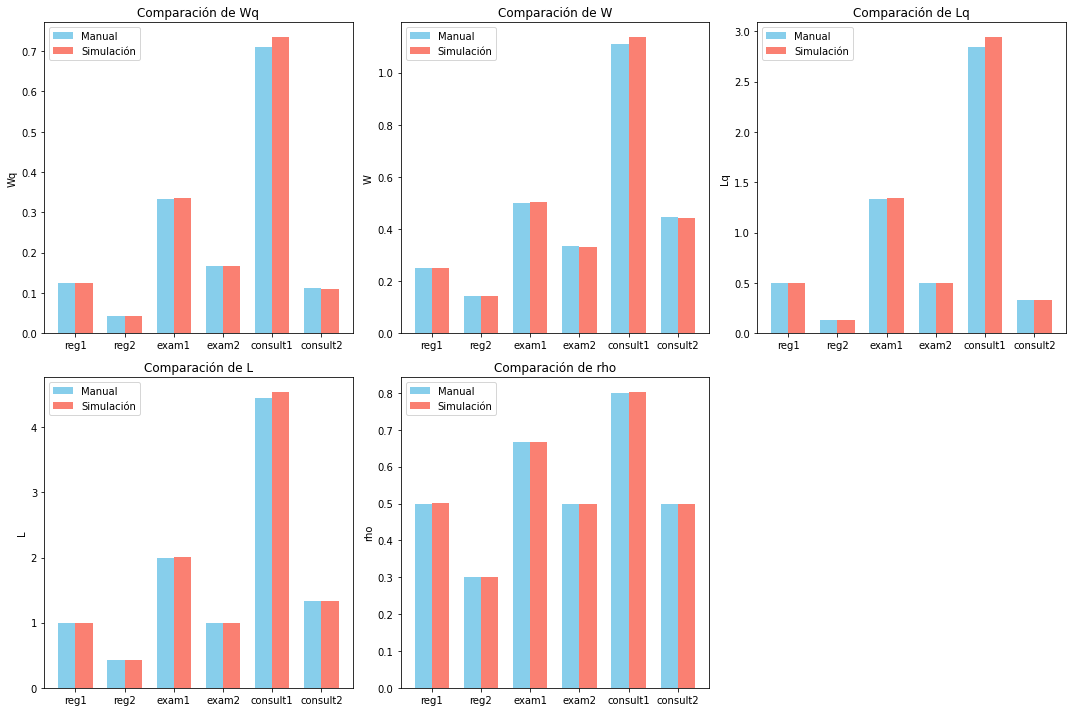

Comparación de métricas entre simulación y cálculo manual para Solución 4:


Simulation                                            Manual  \
                 Wq         W        Lq         L       rho        Wq   
reg1       0.124835  0.249795  0.499991  1.000487  0.500495  0.125000   
reg2       0.042913  0.142874  0.128728  0.428587  0.299860  0.042857   
exam1      0.334520  0.501102  1.339830  2.007030  0.667199  0.333333   
exam2      0.165337  0.331709  0.495973  0.995048  0.499075  0.166667   
consult1   0.276398  0.676834  0.879643  2.154037  0.637197  0.272222   
consult2   0.226448  0.559662  0.865590  2.139285  0.636847  0.226852   

                                                  
                 W        Lq         L       rho  
reg1      0.250000  0.500000  1.000000  0.500000  
reg2      0.142857  0.128571  0.428571  0.300000  
exam1     0.500000  1.333333  2.000000  0.666667  
exam2     0.333333  0.500000  1.000000  0.500000  
consult1  0.672222  0.866162  2.138889  0.636364  
consult2  0.560185  0.866162  2.138889  0.636364

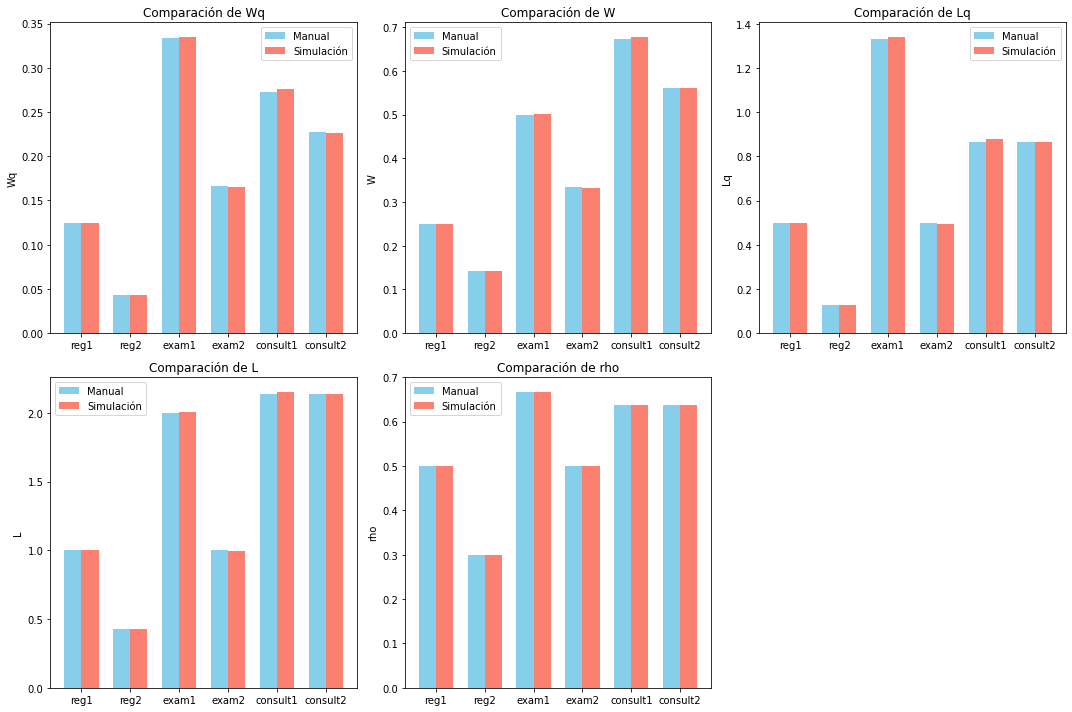

Comparación de métricas entre simulación y cálculo manual para Solución 5:


Simulation                                            Manual  \
                 Wq         W        Lq         L       rho        Wq   
reg1       0.124316  0.249215  0.497090  0.996512  0.499422  0.125000   
reg2       0.042727  0.142894  0.128115  0.428460  0.300345  0.042857   
exam       0.085898  0.252441  0.601034  1.766338  0.582652  0.085965   
consult1   0.270957  0.670718  0.860238  2.129402  0.634582  0.272222   
consult2   0.226911  0.560379  0.867307  2.141897  0.637295  0.226852   

                                                  
                 W        Lq         L       rho  
reg1      0.250000  0.500000  1.000000  0.500000  
reg2      0.142857  0.128571  0.428571  0.300000  
exam      0.252632  0.601754  1.768421  0.583333  
consult1  0.672222  0.866162  2.138889  0.636364  
consult2  0.560185  0.866162  2.138889  0.636364

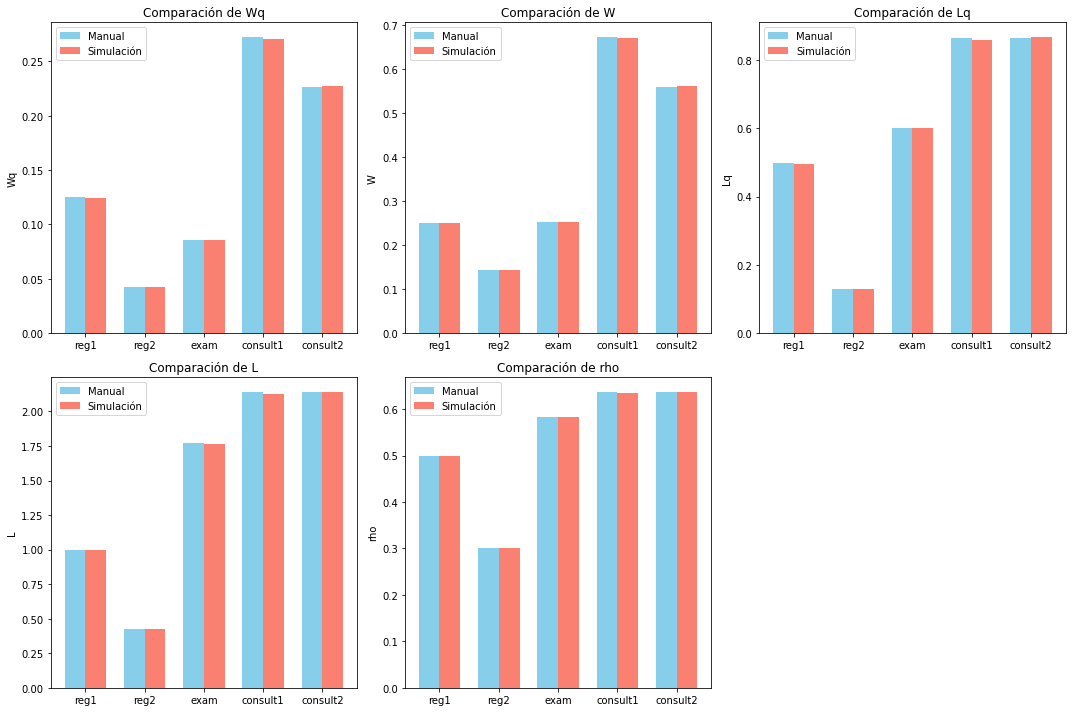

In [809]:
# Extraer de base_metrics las métricas simuladas para los mismos nodos
df_simulation_base = pd.DataFrame(base_metrics).T[metric_names]
df_simulation_sol4 = pd.DataFrame(solution4_metrics).T[metric_names]
df_simulation_sol5 = pd.DataFrame(solution5_metrics).T[metric_names]

# Graficar comparaciones para cada métrica
show_simulated_vs_manual_metrics_comparison_graphs("Base", df_simulation_base, df_base_manual)
show_simulated_vs_manual_metrics_comparison_graphs("Solución 4", df_simulation_sol4, df_solution4_manual)
show_simulated_vs_manual_metrics_comparison_graphs("Solución 5", df_simulation_sol5, df_solution5_manual)


## Comparar medidas de desempeño de la solución 4 y el caso base

In [810]:
def show_cases_comparison(df1: pd.DataFrame, df1_name: str, df2: pd.DataFrame, df2_name: str,
        show_metrics_difference_table: bool = True,
        show_metrics_difference_in_percentage_table: bool = False,
        show_consult_improvement: bool = False,
        show_examination_improvement: bool = False) -> None:
    """
    Muestra una comparación entre dos DataFrames de métricas de casos.
    
    Puede mostrar diferencias absolutas y porcentuales, así como mejoras en
    consultas y examinaciones, por medio de tablas y gráficas.

    Args:
        df1: Dataframe con las métricas del primer caso.
        df2: Dataframe con las métricas del segundo caso.
    """

    if df1.index.tolist() == df2.index.tolist():
        # Reordenar las filas de los DataFrames para que estén en el mismo orden
        nodes_names = df1.index.tolist()

        df1 = df1.reindex(nodes_names)
        df2 = df2.reindex(nodes_names)
    else:
        print("Warning: Los DataFrames no tienen los mismos nodos. No se reordenarán. Puede no ser un problema dependiendo de los casos a comparar.")

    if show_consult_improvement:
        assert "consult1" in df1.index and "consult2" in df1.index, \
            "Para mostrar la mejora en consultas, df1 debe contener los nodos 'consult1' y 'consult2'."
        assert "consult1" in df2.index and "consult2" in df2.index, \
            "Para mostrar la mejora en consultas, df2 debe contener los nodos 'consult1' y 'consult2'."
    
    if show_examination_improvement:
        assert "exam1" in df1.index and "exam2" in df1.index, \
            "Para mostrar la mejora en examinación, df1 debe contener los nodos 'exam1' y 'exam2'."
        assert "exam" in df2.index, \
            "Para mostrar la mejora en examinación, df2 debe contener el nodo 'exam'."
    
    # Combinar df1 y df2 en un solo DataFrame
    df_combined = pd.concat({df1_name: df1, df2_name: df2}, axis=1)

    # Calcular diferencias absolutas y relativas (porcentaje de mejora)
    df_diff = df_combined[df1_name] - df_combined[df2_name]

    if show_consult_improvement:
        # Calcular mejora total en salas de consulta (suma de diferencias absolutas)
        df_total_diff_consult = df_diff.loc[['consult1', 'consult2']].sum(axis=0)

    if show_examination_improvement:
        # Diferencia entre la suma de las métricas del caso del df1 en exam1 y 
        # exam2 con las métricas del caso del df2 en exam
        df_exam_df1 = df1.loc[['exam1', 'exam2']].sum(axis=0)
        df_exam_df2 = df2.loc[['exam']].sum(axis=0)
        df_exam_diff = df_exam_df1 - df_exam_df2
        # Sólo nos interesan las métricas de longitudes de cola
        df_exam_diff = df_exam_diff[['Lq', 'L']]

    # Mostrar tablas
    print(f"=== Comparativa {df1_name} vs {df2_name} ===")
    display(df_combined)
    
    if show_metrics_difference_table:
        print(f"\n=== Diferencias absolutas ({df1_name} - {df2_name}) ===")
        display(df_diff.round(4))

    if show_metrics_difference_in_percentage_table:
        df_pct  = (df_diff / df_combined[df1_name]) * 100
        print(f"\n=== Diferencia porcentual (%) ===")
        display(df_pct.round(2))
        
    if show_examination_improvement:
        print("\n=== Mejoras en la sala de examinación ===")
        display(df_exam_diff.round(4))

    if show_consult_improvement:
        # Graficar mejoras totales en consultas
        plt.figure(figsize=(8, 6))
        ax = df_total_diff_consult.plot(kind='bar', color='lightgreen')
        plt.title('Mejoras Totales en Salas de Consulta')
        plt.xlabel('Métricas')
        plt.ylabel(f'Mejora ({df1_name} - {df2_name})')
        plt.xticks(rotation=45)

        # Mostrar el valor encima de cada barra
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2, p.get_height()),
                        ha='center', va='bottom', fontsize=13, color='black')
    
    # Graficar métricas por nodo (df1 vs df2)
    metrics = ['Wq','W','Lq','L','rho']

    fig, axes = plt.subplots(2, 3, figsize=(20, 12))  # Aumentar el tamaño de la figura
    axes = axes.flatten()

    # Concatenar combined y diff para graficar
    df_plot = pd.concat({df1_name: df1, df2_name: df2, 'Diff': df_diff}, axis=1)

    for ax, metric in zip(axes, metrics):
        # Extraer las tres columnas (df1, df2 y Diff) para la métrica actual
        df_plot_metric = df_plot.loc[:, (slice(None), metric)]
        # Quitar el nivel de índice de columna que sobra
        df_plot_metric.columns = df_plot_metric.columns.droplevel(1)
        df_plot_metric.plot(kind='bar', ax=ax, color=['skyblue', 'salmon', 'lightgreen'])
        ax.set_title(f"Métrica: {metric}")
        ax.set_ylabel(metric)
        ax.legend([df1_name, df2_name, 'Diferencia'])

    plt.tight_layout()
    plt.show()


=== Comparativa Base vs Solución 4 ===


Base                                         Solución 4  \
                Wq         W        Lq         L       rho         Wq   
reg1      0.125000  0.250000  0.500000  1.000000  0.500000   0.125000   
reg2      0.042857  0.142857  0.128571  0.428571  0.300000   0.042857   
exam1     0.333333  0.500000  1.333333  2.000000  0.666667   0.333333   
exam2     0.166667  0.333333  0.500000  1.000000  0.500000   0.166667   
consult1  0.711111  1.111111  2.844444  4.444444  0.800000   0.272222   
consult2  0.111111  0.444444  0.333333  1.333333  0.500000   0.226852   

                                                  
                 W        Lq         L       rho  
reg1      0.250000  0.500000  1.000000  0.500000  
reg2      0.142857  0.128571  0.428571  0.300000  
exam1     0.500000  1.333333  2.000000  0.666667  
exam2     0.333333  0.500000  1.000000  0.500000  
consult1  0.672222  0.866162  2.138889  0.636364  
consult2  0.560185  0.866162  2.138889  0.636364


=== Diferencias absolutas (Base - Solución 4) ===


,Wq,W,Lq,L,rho
reg1,0.0000,0.0000,0.0000,0.0000,0.0000
reg2,0.0000,0.0000,0.0000,0.0000,0.0000
exam1,0.0000,0.0000,0.0000,0.0000,0.0000
exam2,0.0000,0.0000,0.0000,0.0000,0.0000
consult1,0.4389,0.4389,1.9783,2.3056,0.1636
consult2,-0.1157,-0.1157,-0.5328,-0.8056,-0.1364


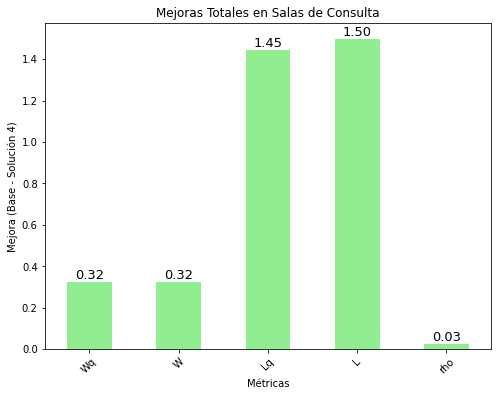

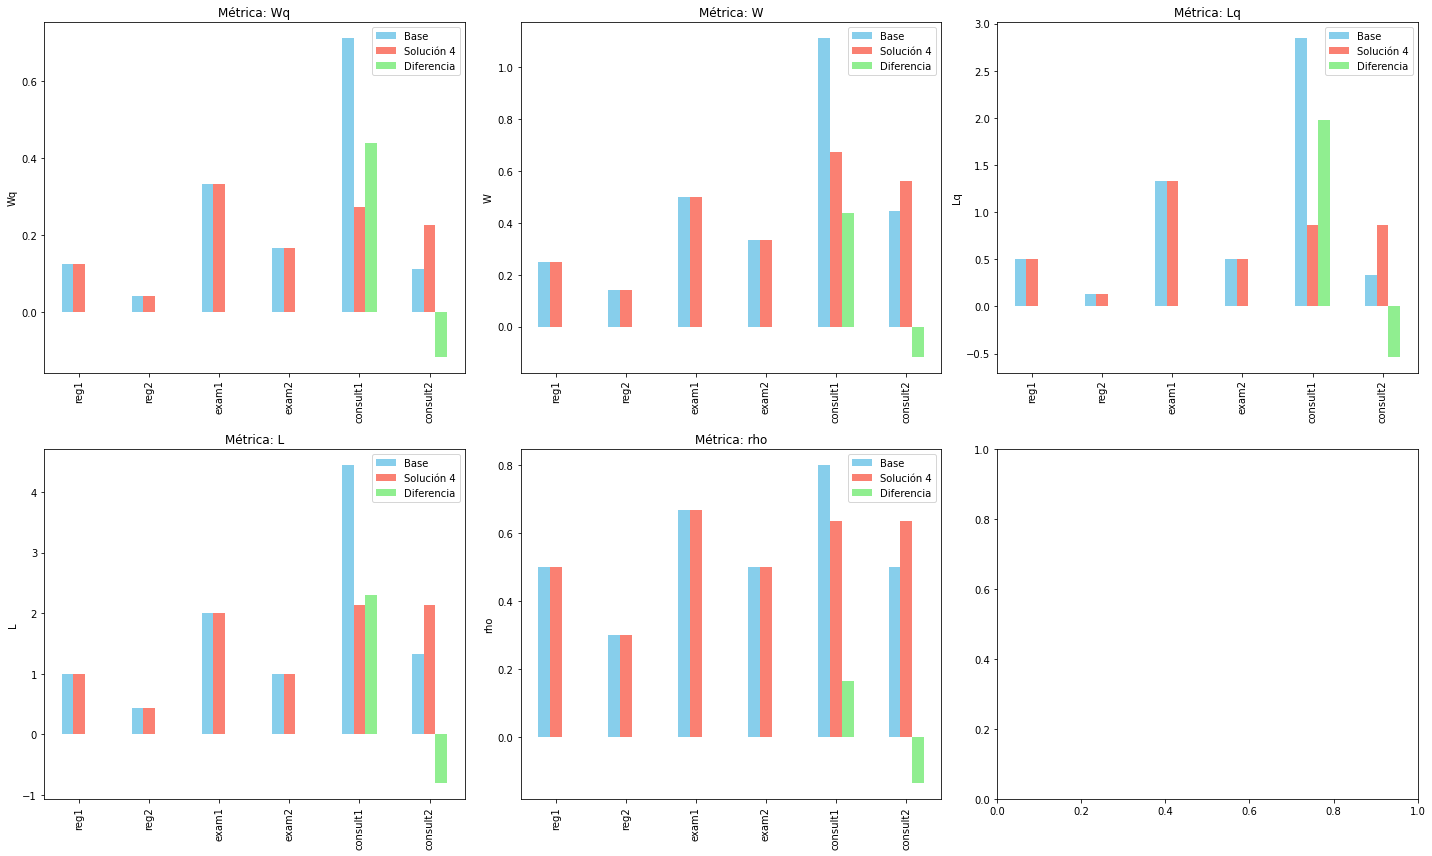

In [811]:
# Convertir los dict de métricas a DataFrames
df1 = pd.DataFrame(base_metrics_manual).T
df2 = pd.DataFrame(solution4_metrics_manual).T

show_cases_comparison(df1, "Base", df2, "Solución 4", show_consult_improvement=True)


### Interpretación de los resultados

Al permitir que los pacientes de las salas de examinación se dirijan hacia alguno de los dos consultorios por medio de probabilidades de enrutamiento, $\rho$ toma el mismo valor en el consultorio 1 y en el consultorio 2 (pues el flujo de salida de las salas de examinación se dirige de forma proporcional a las tasas de servicio de los consultorios; es como si se tuviera un $\lambda = 4+3 = 7$ total, que el porcentaje $\mu_{c1} / (\mu_{c1} + \mu_{c2})$ se asigna al consultorio 1, quedando $\lambda_{c1} = 7 \cdot \frac{\mu_{c1}}{\mu_{c1} + \mu_{c2}} \rightarrow \rho_{c1} = \frac{\lambda_{c1}}{s \cdot \mu_{c1}} = \frac{7 \cdot \frac{\mu_{c1}}{\mu_{c1} + \mu_{c2}}}{2 \cdot \mu_{c1}}$ = $\frac{7}{2 \cdot (\mu_{c1} + \mu_{c2})}$; para el consultorio 2 se realiza el mismo cálculo y termina $\lambda_{c2} = 7 \cdot \frac{\mu_{c2}}{\mu_{c1} + \mu_{c2}} \rightarrow \rho_{c2} = \frac{7}{2 \cdot (\mu_{c1} + \mu_{c2})} = \rho_{c1}$). Esto es un indicador de que ambas estaciones de servicio tienen la misma fracción esperada de tiempo que los servidores individuales están ocupados. **Con este enrutamiento, la fracción esperada de tiempo que cada consultorio está ocupado es de $63\% < 70\%$, evitando fatiga excesiva en los médicos**.

Los tiempos de espera se reducen mucho para el consultorio 1 y aumentan muy poco en el consultorio 2; lo mismo pasa para la cantidad de pacientes esperando en fila.

**En la suma de los tiempos promedio de espera en cola hacia las salas de consulta ($W_{q_{c1}} + W_{q_{c2}}$) se demostró una reducción total de 20 minutos/paciente:**

* En la sala 1: 0.7111 horas/paciente $\rightarrow$ 0.2722 horas/paciente $\rightarrow$ $-0.44$ horas/paciente.
* En la sala 2: 0.11 horas/paciente $\rightarrow$ 0.22 horas/paciente $\rightarrow$ $+0.11$ horas/paciente.
* Hubo una reducción total de $0.33$ horas/paciente en promedio entre ambos consultorios.

**En la suma de la cantidad promedio de clientes en cola en cualquier instante hacia las salas de consulta ($L_{q_{c1}} + L_{q_{c2}}$) se demostró una reducción total de $1.45$ pacientes:**

* En la sala 1: 2.844 pacientes $\rightarrow$ 0.866 pacientes $\rightarrow$ $-1.9783$ pacientes.
* En la sala 2: 0.33 pacientes $\rightarrow$ 0.0.866 pacientes $\rightarrow$ $+0.5328$ pacientes.
* Hubo una reducción total de $1.45$ en la cantidad promedio de pacientes en cola en cualquier instante, entre ambos consultorios.

## Comparar medidas de desempeño de la solución 5 y la solución 4

=== Comparativa Solución 4 vs Solución 5 ===


Solución 4                                         Solución 5  \
                 Wq         W        Lq         L       rho         Wq   
reg1       0.125000  0.250000  0.500000  1.000000  0.500000   0.125000   
reg2       0.042857  0.142857  0.128571  0.428571  0.300000   0.042857   
exam1      0.333333  0.500000  1.333333  2.000000  0.666667        NaN   
exam2      0.166667  0.333333  0.500000  1.000000  0.500000        NaN   
consult1   0.272222  0.672222  0.866162  2.138889  0.636364   0.272222   
consult2   0.226852  0.560185  0.866162  2.138889  0.636364   0.226852   
exam            NaN       NaN       NaN       NaN       NaN   0.085965   

                                                  
                 W        Lq         L       rho  
reg1      0.250000  0.500000  1.000000  0.500000  
reg2      0.142857  0.128571  0.428571  0.300000  
exam1          NaN       NaN       NaN       NaN  
exam2          NaN       NaN       NaN       NaN  
consult1  0.672222  0.866162  2.138889  0.636364  
consult2  0.560185  0.866162  2.138889  0.636364  
exam      0.252632  0.601754  1.768421  0.583333


=== Diferencias absolutas (Solución 4 - Solución 5) ===


,Wq,W,Lq,L,rho
reg1,0.0,0.0,0.0,0.0,0.0
reg2,0.0,0.0,0.0,0.0,0.0
exam1,NaN,NaN,NaN,NaN,NaN
exam2,NaN,NaN,NaN,NaN,NaN
consult1,0.0,0.0,0.0,0.0,0.0
consult2,0.0,0.0,0.0,0.0,0.0
exam,NaN,NaN,NaN,NaN,NaN



=== Mejoras en la sala de examinación ===


Lq    1.2316
L     1.2316
dtype: float64

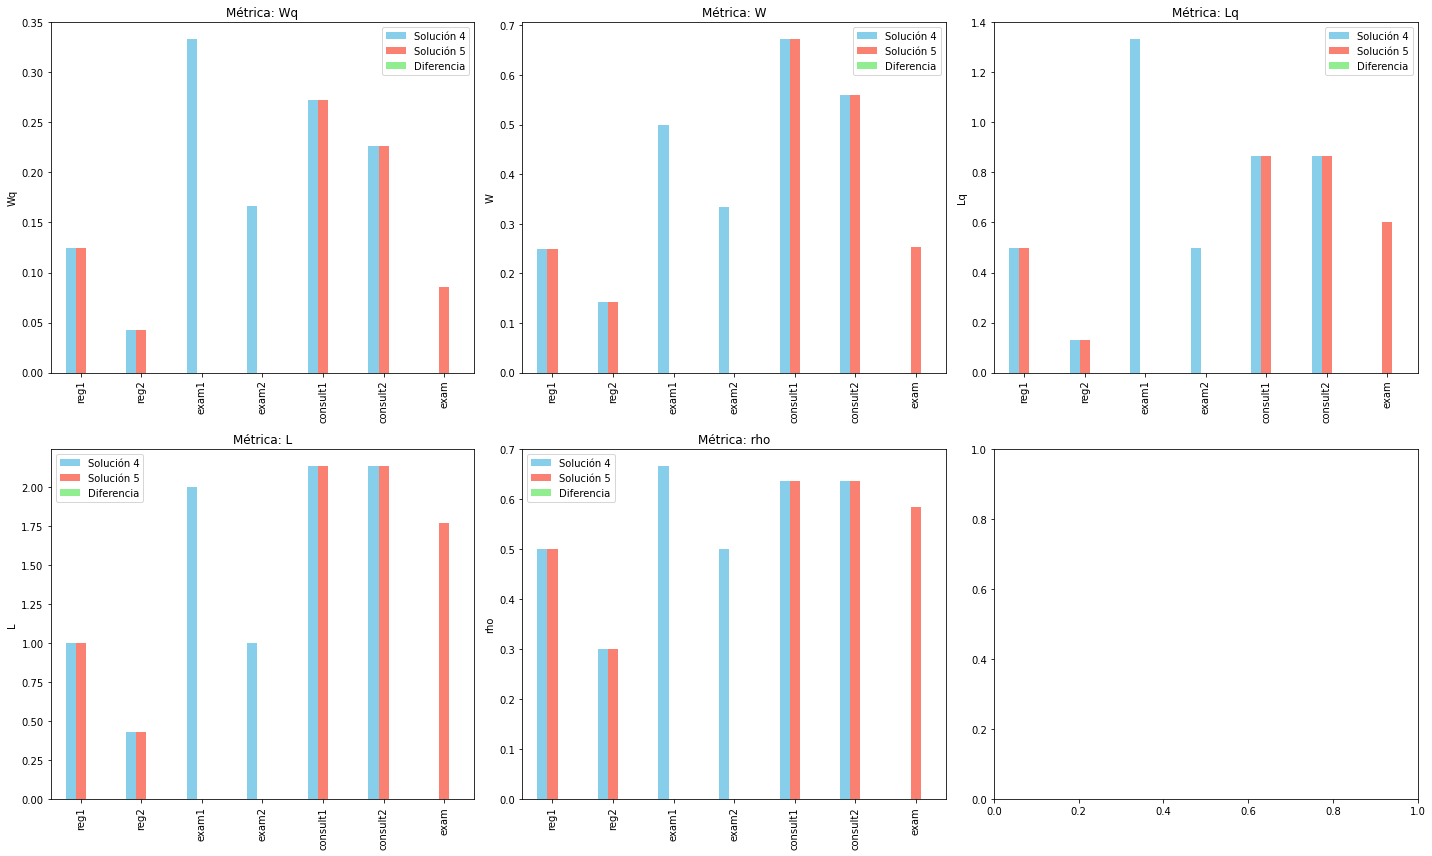

In [812]:
# Convertir los dict de métricas a DataFrames
df1 = pd.DataFrame(solution4_metrics_manual).T
df2 = pd.DataFrame(solution5_metrics_manual).T

show_cases_comparison(df1, "Solución 4", df2, "Solución 5", show_examination_improvement=True)

### Interpretación de los resultados

Generalmente dos instalaciones de servicio con un solo servidor separadas que realizan la misma función con la misma tasa de servicio son menos eficientes que una sola instalación de servicio con dos servidores. A esto se le conoce como queue pooling.

Al juntar las dos salas de examinación en una sola, se obtienen los siguientes resultados comparando la suma de las métricas de desempeño de ambas salas de examinación con las métricas de la nueva sala de examinación única que las reemplaza:

1. La cantidad total media en cualquier instante de clientes en espera para ser examinados ($L_{q_{e1}} + L_{q_{e2}}$ en la solución 4; $L_{q_{e}}$ en la solución 5) se reduce en 1.23 clientes.
2. El tiempo medio de espera en cola ($W_q$) y el tiempo medio de cada cliente en examinación ($W$) son menores en la nueva sala de examinación con 2 enfermeros que en cualquiera de las dos salas de examinación antiguas con 1 enfermero.

## Comparar medidas de desempeño de la solución 5 (final) y del caso base

Las mejoras de la solución 4 respecto con el caso base y de la solución 5 respecto con la solución 4 se ven en las $W$, $W_q$, $L$ y $L_q$ de las salas de consulta y de la sala de examinación nueva y única.

=== Comparativa Base vs Solución 5 ===


Base                                         Solución 5  \
                Wq         W        Lq         L       rho         Wq   
reg1      0.125000  0.250000  0.500000  1.000000  0.500000   0.125000   
reg2      0.042857  0.142857  0.128571  0.428571  0.300000   0.042857   
exam1     0.333333  0.500000  1.333333  2.000000  0.666667        NaN   
exam2     0.166667  0.333333  0.500000  1.000000  0.500000        NaN   
consult1  0.711111  1.111111  2.844444  4.444444  0.800000   0.272222   
consult2  0.111111  0.444444  0.333333  1.333333  0.500000   0.226852   
exam           NaN       NaN       NaN       NaN       NaN   0.085965   

                                                  
                 W        Lq         L       rho  
reg1      0.250000  0.500000  1.000000  0.500000  
reg2      0.142857  0.128571  0.428571  0.300000  
exam1          NaN       NaN       NaN       NaN  
exam2          NaN       NaN       NaN       NaN  
consult1  0.672222  0.866162  2.138889  0.636364  
consult2  0.560185  0.866162  2.138889  0.636364  
exam      0.252632  0.601754  1.768421  0.583333


=== Mejoras en la sala de examinación ===


Lq    1.2316
L     1.2316
dtype: float64

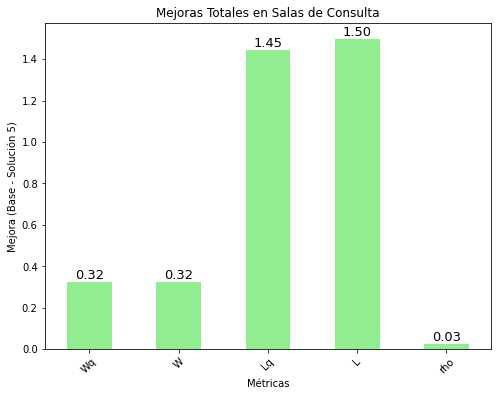

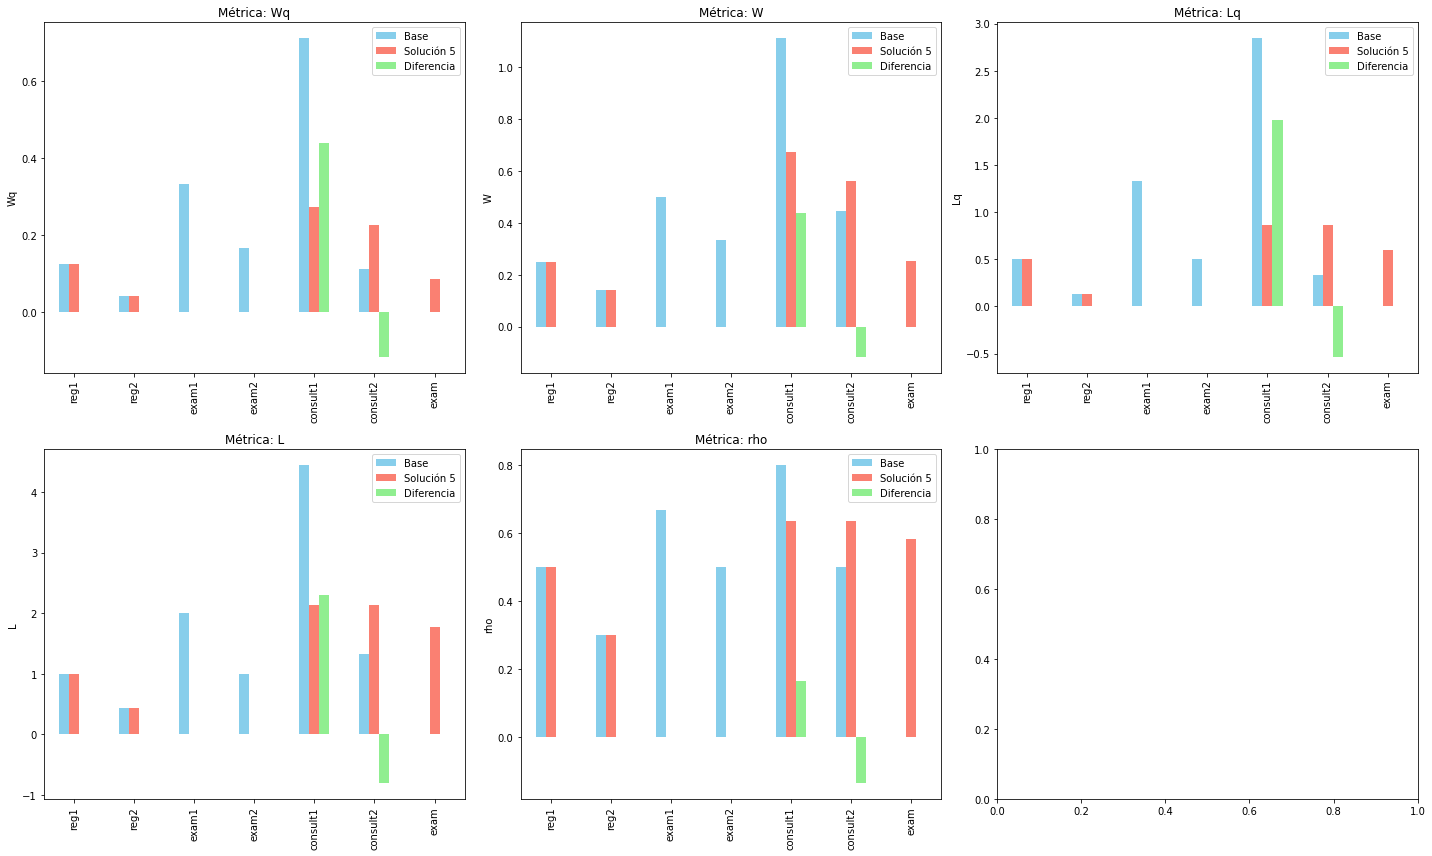

In [813]:
# Convertir los dict de métricas a DataFrames
df1 = pd.DataFrame(base_metrics_manual).T
df2 = pd.DataFrame(solution5_metrics_manual).T

show_cases_comparison(df1, "Base", df2, "Solución 5",
    show_metrics_difference_table=False, show_consult_improvement=True,
    show_examination_improvement=True)

# Después de terminar la Notebook

* **Mostrar una comparación de las medidas de desempeño obtenidas manualmente (basándose en los resultados que da el código como `cálculos manuales`, como `base_metrics_manual`)** utilizando las fórmulas del Hillier Lieberman para cada nodo. Cómo se calculan los $\lambda$ de cada nodo se puede ver fácilmente en https://www.youtube.com/watch?v=OkHWnTHaOzY. Con tener los $\lambda$ de cada nodo, los $\mu$ ya se dan en la celda que define los nodos en los datos de entrada antes de correr la simulación (`nodes_base`, por ejemplo). Anotar los resultados de cada nodo del caso base y de las soluciones 4 y 5; de la solución 3, mencionar que como $\lambda$ > $\mu$, el sistema no llega a alcanzar un estado estable y por lo tanto las fórmulas mostradas en el Hillier Lieberman divergen. No hace falta escribirse todo el desarrollo de las fórmulas; sólo anotar las fórmulas generales, y por cada nodo de cada caso (base, 4 y 5) escribir directamente el resultado que da el código, mencionando que las funciones mm1_metrics y mms_metrics realizan los cálculos basándose en las fórmulas del libro.

* **Escribir la interpretación de resultados en el Word**.

* **Escribir la introducción, descripción, etc.**

```
 Presentación del proyecto final  
El proyecto final se presentará como:
 
• Presentación / Documento
Es preferible tener una presentación para apoyarse en el momento de las
exposiciones, sin embargo, se puede presentar solamente el documento con la
información referente al proyecto.
 
El tema del proyecto es Teoría de colas por lo que se espera una introducción al tema,
la descripción del modelo a utilizar, con todos los parámetros, al menos una
representación visual (gráfica) de la situación en la que se basa el proyecto y resolver
alguna situación o buscar mejorar los tiempos de atención al cliente o la reducción
de los tiempos de espera.
 
Deberá presentarse el análisis del sistema de colas, explicando que es y que
representa en el contexto a tratar  
o Fuente de entrada  
o Variables utilizadas, parámetros
o Tipo de población  
o Tasa de llegada  
o Mecanismo de servicio  
o Disciplina de la cola
o Tiempos de espera
o Longitud de cola  
o Disciplina de servicio
o Distribución de salida
 
• Exposición  
Cada uno de los integrantes del equipo deberá tener una participación mínima de 3
minutos. En total la participación de cada equipo deberá durar entre 10 y 15 minutos,
en donde se explicará el contenido del documento/presentación, así como el código
utilizado y deberán ser capaces de responder preguntas realizadas por sus
compañeros y docente.
 
• Código  
Solver comercial (Python o R), donde se trabajó la base de datos para simular
llegadas y salidas al sistema de colas, además del efecto de la solución propuesta,
así como la comparación de ambos sistemas.
*Se podrán hacer ajustes a las indicaciones en caso de que se requiera especificar
algo más.
```
